- 02_Customer_Dimension_Analysis.ipynb
- Algerie Telecom Customer Dimension Deep Analysis
- Author: Zakaria ALIZOUAOUI
- Date: July 2025


# 👥 Customer Dimension Analysis
 
Deep dive into customer demographics, segmentation, and behavioral patterns.
 
## Objectives:
 - Analyze customer demographics and distribution
 - Understand service adoption patterns
 - Identify high-value customer segments
 - Analyze churn patterns and risk factors


## 1. Environment Setup

In [13]:
import sys
sys.path.append('/home/jovyan/work/batch/jupyter/notebooks/work/scripts')
from spark_init import init_spark
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import hashlib
from pyspark.sql import functions as F, types as T
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.types import *
from datetime import datetime
from datetime import datetime, timedelta

spark.sparkContext.setLogLevel("WARN")


# Initialize Spark with proper configuration
spark = init_spark("AT Customer Dimension Analysis - Generated AT CDR")
print("✅ SparkSession initialized")

✅ SparkSession initialized (App: AT Customer Dimension Analysis - Generated AT CDR, Spark: 3.5.1)
✅ Hive Warehouse: hdfs://namenode:9000/user/hive/warehouse
✅ Hive Metastore URI: thrift://hive-metastore:9083
✅ SparkSession initialized


In [3]:
!ls /home/jovyan/work/scripts


dev-batch.sh	  init-datanode.sh   setup
dev-streaming.sh  logs-batch.sh      start-hdfs.sh
hdfs		  logs-streaming.sh  stop-all.sh


In [4]:
import os
print(os.path.exists('/home/jovyan/work/batch/jupyter/notebooks/work/scripts/spark_init.py'))


True


## 2. Load Customer Data

In [14]:

# Load customer dimension
customers_df = spark.read.parquet("/user/hive/warehouse/Raw/customer_dim_enhanced/")

# Cache for performance
customers_df.cache()

print(f"Total Customers: {customers_df.count():,}")
print(f"Columns: {', '.join(customers_df.columns)}")

# Add derived columns for analysis
customers_df = customers_df.withColumn(
    "tenure_days",
    datediff(lit("2025-07-19"), col("activation_date"))
).withColumn(
    "tenure_months",
    round(col("tenure_days") / 30, 1)
).withColumn(
    "tenure_category",
    when(col("tenure_months") < 3, "New")
    .when(col("tenure_months") < 12, "Regular")
    .when(col("tenure_months") < 24, "Loyal")
    .otherwise("VIP")
)

Total Customers: 530,719
Columns: customer_id, connection_id, wilaya_code, wilaya_name, customer_type, service_type, offer_name, offer_price, activation_date, is_active, tech_adoption_score, business_score, network_quality_score, usage_profile, bandwidth_mbps, boost_hours, night_boost, sla_percentage, data_cap_gb, upload_mbps, days_active, is_new_customer


25/07/06 13:22:47 WARN CacheManager: Asked to cache already cached data.


## 3. Customer Demographics Overview

Customer Type Distribution:
  customer_type   count  percentage  wilayas_present  avg_network_quality
0   PARTICULIER  524913       98.91               58                0.822
1           PRO    4471        0.84               58                0.822
2       STUDENT     874        0.16               58                0.823
3    FREELANCER     371        0.07               58                0.827
4       STARTUP      90        0.02               48                0.845


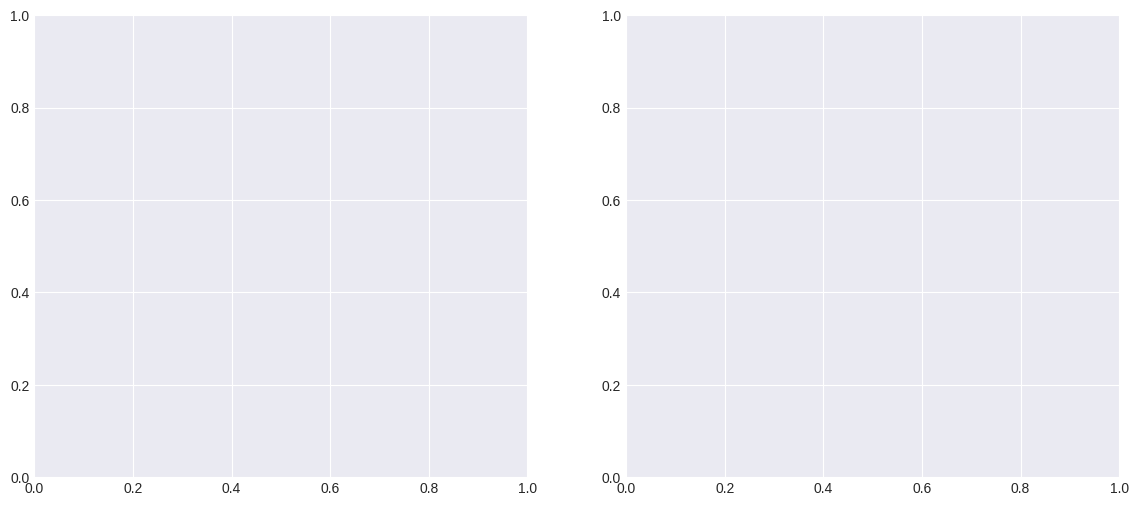

In [15]:
# Customer type distribution
customer_type_dist = customers_df.groupBy("customer_type").agg(
    count("*").alias("count"),
    round(count("*") * 100.0 / customers_df.count(), 2).alias("percentage"),
    countDistinct("wilaya_code").alias("wilayas_present"),
    round(avg("network_quality_score"), 3).alias("avg_network_quality")
).orderBy(col("count").desc()).toPandas()

print("Customer Type Distribution:")
print(customer_type_dist)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

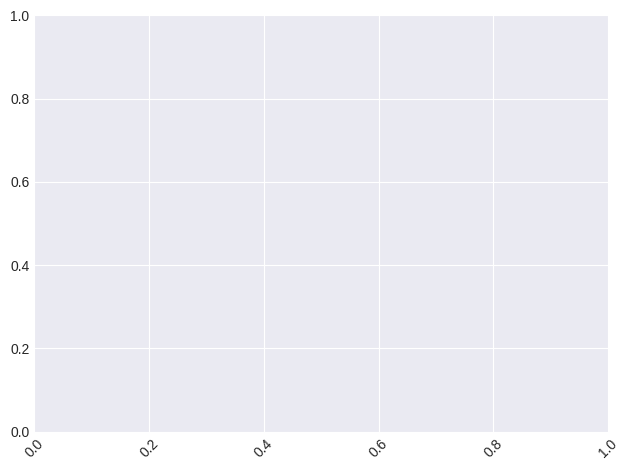

In [16]:

# Pie chart
ax1.pie(customer_type_dist['count'], 
        labels=customer_type_dist['customer_type'], 
        autopct='%1.1f%%',
        startangle=90)
ax1.set_title('Customer Type Distribution')

# Bar chart with network quality
ax2.bar(customer_type_dist['customer_type'], customer_type_dist['count'])
ax2.set_xlabel('Customer Type')
ax2.set_ylabel('Count')
ax2.set_title('Customer Count by Type')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## 4. Service Type Analysis

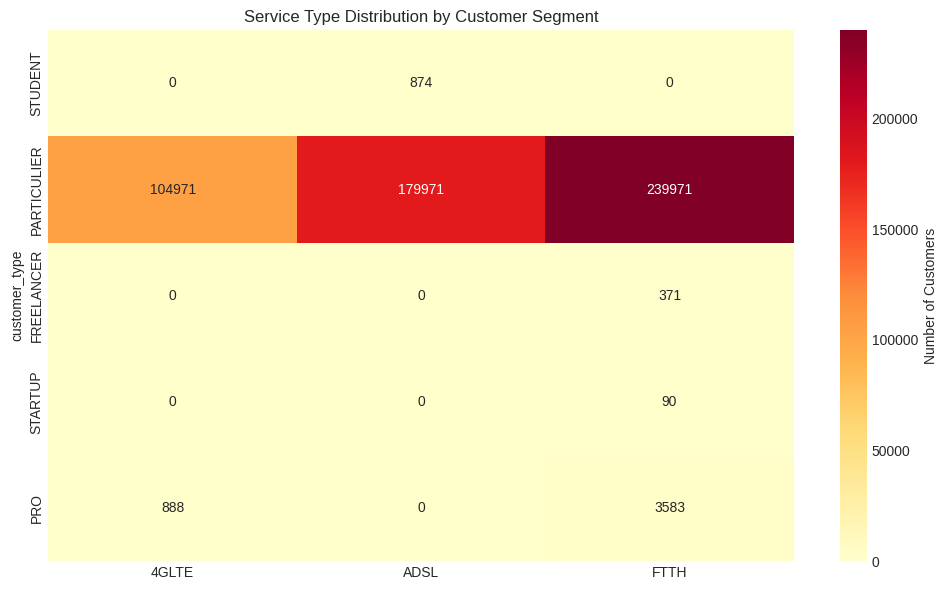


Service Penetration Rates (%):
               4GLTE   ADSL   FTTH
customer_type                     
STUDENT          0.0  100.0    0.0
PARTICULIER     20.0   34.3   45.7
FREELANCER       0.0    0.0  100.0
STARTUP          0.0    0.0  100.0
PRO             19.9    0.0   80.1


In [17]:
# Service adoption by customer type
service_by_type = customers_df.groupBy("customer_type", "service_type").count() \
    .groupBy("customer_type").pivot("service_type").sum("count").fillna(0).toPandas()

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(service_by_type.set_index('customer_type'), 
            annot=True, 
            fmt='g', 
            cmap='YlOrRd',
            cbar_kws={'label': 'Number of Customers'})
plt.title('Service Type Distribution by Customer Segment')
plt.tight_layout()
plt.show()

# Service penetration rates
total_by_type = customers_df.groupBy("customer_type").count().toPandas()
service_penetration = service_by_type.set_index('customer_type').div(
    total_by_type.set_index('customer_type')['count'], axis=0) * 100

print("\nService Penetration Rates (%):")
print(service_penetration.round(1))


## 5. Geographic Distribution Analysis

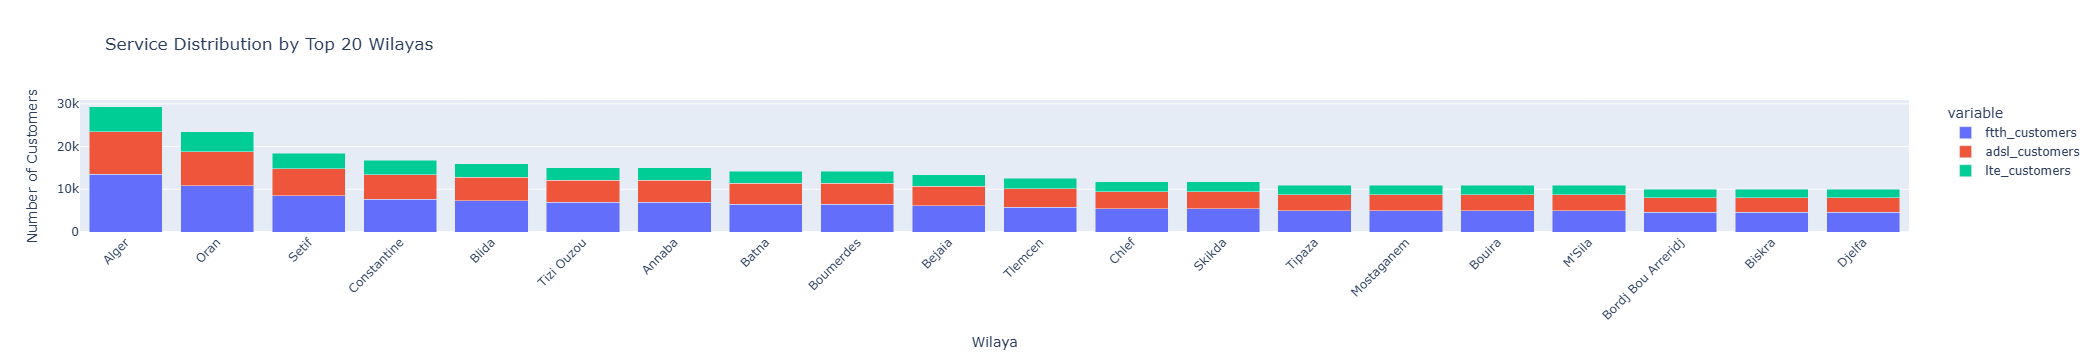

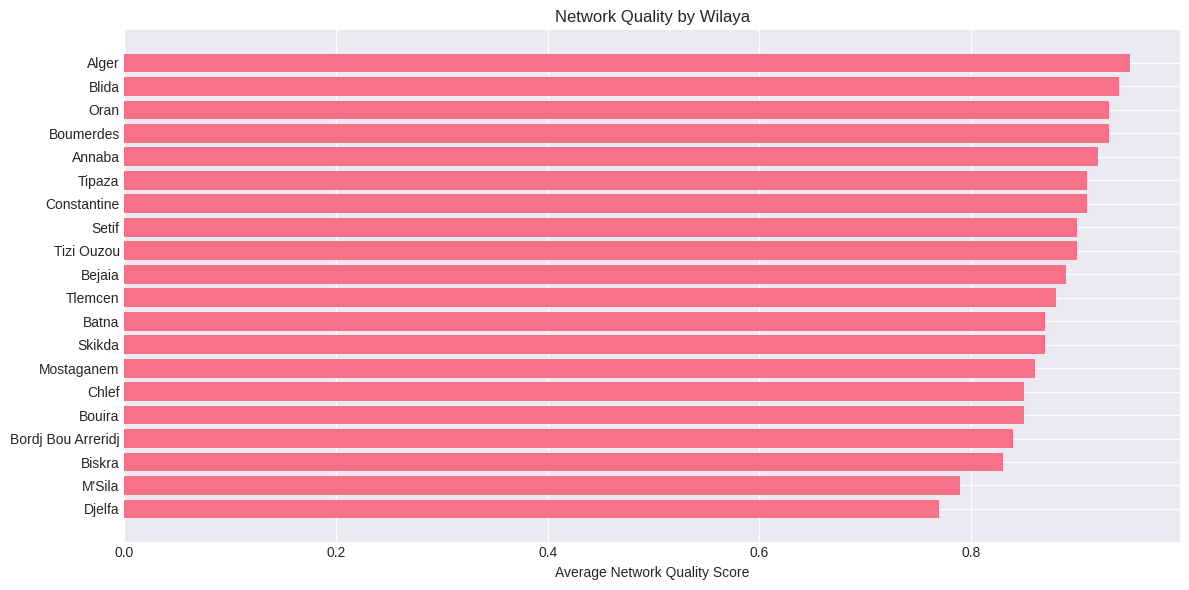

In [18]:
# Top wilayas analysis
wilaya_analysis = customers_df.groupBy("wilaya_code", "wilaya_name").agg(
    count("*").alias("total_customers"),
    sum(when(col("service_type") == "FTTH", 1).otherwise(0)).alias("ftth_customers"),
    sum(when(col("service_type") == "ADSL", 1).otherwise(0)).alias("adsl_customers"),
    sum(when(col("service_type") == "4GLTE", 1).otherwise(0)).alias("lte_customers"),
    avg("network_quality_score").alias("avg_network_quality"),
    sum(when(col("customer_type") == "PRO", 1).otherwise(0)).alias("business_customers"),
    avg("tech_adoption_score").alias("avg_tech_adoption")
).orderBy(col("total_customers").desc()).limit(20).toPandas()

# Create geographic visualization
fig = px.bar(wilaya_analysis, 
             x='wilaya_name', 
             y=['ftth_customers', 'adsl_customers', 'lte_customers'],
             title='Service Distribution by Top 20 Wilayas',
             labels={'value': 'Number of Customers', 'wilaya_name': 'Wilaya'})
fig.update_layout(barmode='stack', xaxis_tickangle=-45)
fig.show()

# Network quality by region
plt.figure(figsize=(12, 6))
wilaya_analysis_sorted = wilaya_analysis.sort_values('avg_network_quality', ascending=True)
plt.barh(wilaya_analysis_sorted['wilaya_name'], wilaya_analysis_sorted['avg_network_quality'])
plt.xlabel('Average Network Quality Score')
plt.title('Network Quality by Wilaya')
plt.tight_layout()
plt.show()


## 6. Customer Value Segmentation

Customer Value Segmentation:
  value_segment  customer_count  avg_monthly_revenue  total_monthly_revenue  \
0  Medium Value          320355          2026.525729              635923700   
1    High Value          160337          3185.810512              500776900   
2     Low Value           18795          1293.636605               23801200   
3       Premium           31232          7824.551742              239470400   

   avg_tenure_months  churn_rate  revenue_contribution  
0          16.187508    0.020415             45.424023  
1          16.252547    0.019765             35.770489  
2          16.301591    0.021069              1.700119  
3          16.156138    0.020108             17.105368  


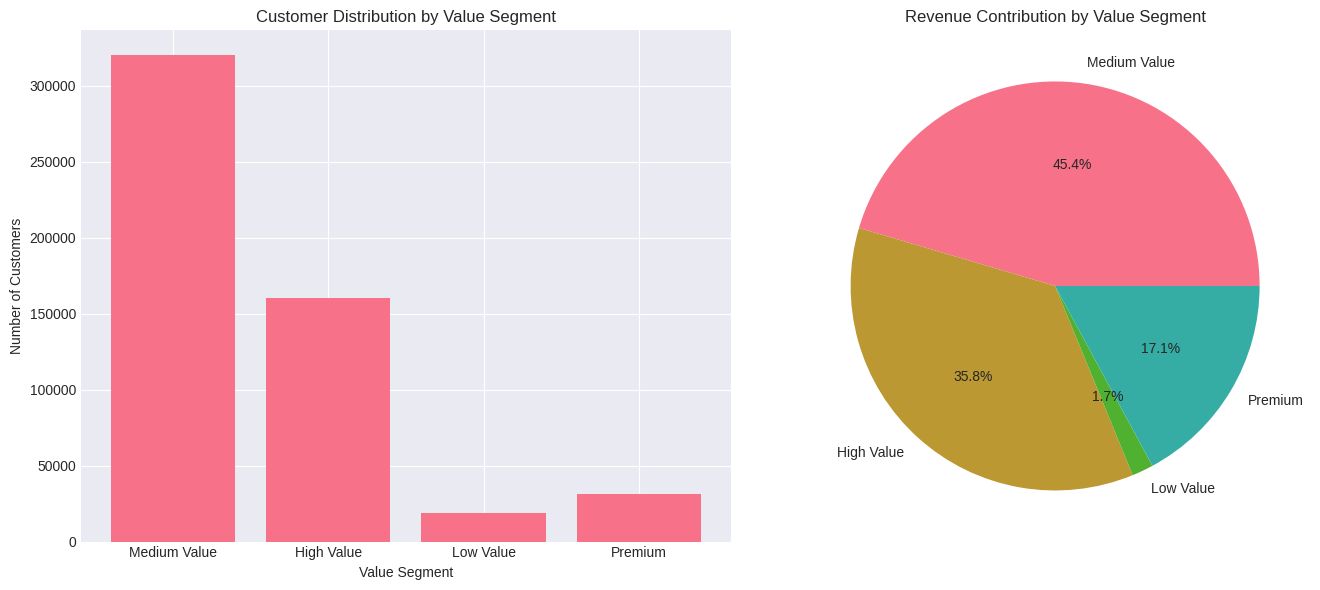

In [19]:
# Calculate customer value segments based on offer price
customers_df = customers_df.withColumn(
    "value_segment",
    when(col("offer_price") < 1500, "Low Value")
    .when(col("offer_price") < 2500, "Medium Value")
    .when(col("offer_price") < 5000, "High Value")
    .otherwise("Premium")
)

# Value segment analysis
value_analysis = customers_df.groupBy("value_segment").agg(
    count("*").alias("customer_count"),
    avg("offer_price").alias("avg_monthly_revenue"),
    sum(when(col("is_active"), col("offer_price")).otherwise(0)).alias("total_monthly_revenue"),
    avg("tenure_months").alias("avg_tenure_months"),
    (1 - avg(col("is_active").cast("double"))).alias("churn_rate")
).toPandas()

# Calculate total revenue contribution
value_analysis['revenue_contribution'] = (value_analysis['total_monthly_revenue'] / 
                                         value_analysis['total_monthly_revenue'].sum() * 100)

print("Customer Value Segmentation:")
print(value_analysis)

# Visualize value segments
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Customer count by value segment
ax1.bar(value_analysis['value_segment'], value_analysis['customer_count'])
ax1.set_xlabel('Value Segment')
ax1.set_ylabel('Number of Customers')
ax1.set_title('Customer Distribution by Value Segment')

# Revenue contribution
ax2.pie(value_analysis['revenue_contribution'], 
        labels=value_analysis['value_segment'],
        autopct='%1.1f%%')
ax2.set_title('Revenue Contribution by Value Segment')

plt.tight_layout()
plt.show()

## 7. Bandwidth and Offer Analysis

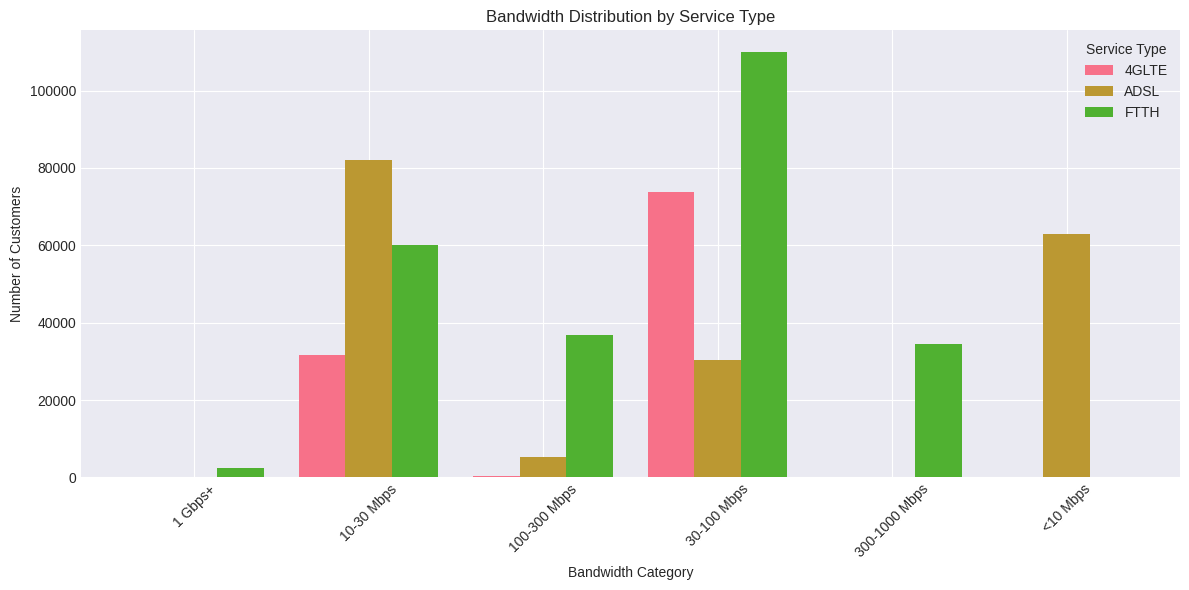

In [20]:
# Bandwidth distribution for customers with bandwidth info
bandwidth_customers = customers_df.filter(col("bandwidth_mbps").isNotNull())

# Create bandwidth categories
bandwidth_customers = bandwidth_customers.withColumn(
    "bandwidth_category",
    when(col("bandwidth_mbps") < 10, "<10 Mbps")
    .when(col("bandwidth_mbps") < 30, "10-30 Mbps")
    .when(col("bandwidth_mbps") < 100, "30-100 Mbps")
    .when(col("bandwidth_mbps") < 300, "100-300 Mbps")
    .when(col("bandwidth_mbps") < 1000, "300-1000 Mbps")
    .otherwise("1 Gbps+")
)

# Bandwidth analysis by service type
bandwidth_dist = bandwidth_customers.groupBy("service_type", "bandwidth_category").count() \
    .orderBy("service_type", "bandwidth_category").toPandas()

# Create grouped bar chart
pivot_bandwidth = bandwidth_dist.pivot(index='bandwidth_category', 
                                      columns='service_type', 
                                      values='count').fillna(0)

ax = pivot_bandwidth.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title('Bandwidth Distribution by Service Type')
plt.xlabel('Bandwidth Category')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.legend(title='Service Type')
plt.tight_layout()
plt.show()

## 8. Churn Analysis

=== Starting Fixed Churn Analysis ===
Calculating churn by customer type...
Churn Analysis by Customer Type:
  customer_type   total  churned  churn_rate  avg_churned_tenure
0       STARTUP      90        1    1.111111           22.700000
1    FREELANCER     371        7    1.886792           18.200000
2       STUDENT     874       17    1.945080           17.976471
3           PRO    4471       89    1.990606           16.295506
4   PARTICULIER  524913    10619    2.023002           16.276909


Creating churn visualizations...
Calculating churn by tenure...
Analyzing network quality distribution...
Calculating churn by value segment...


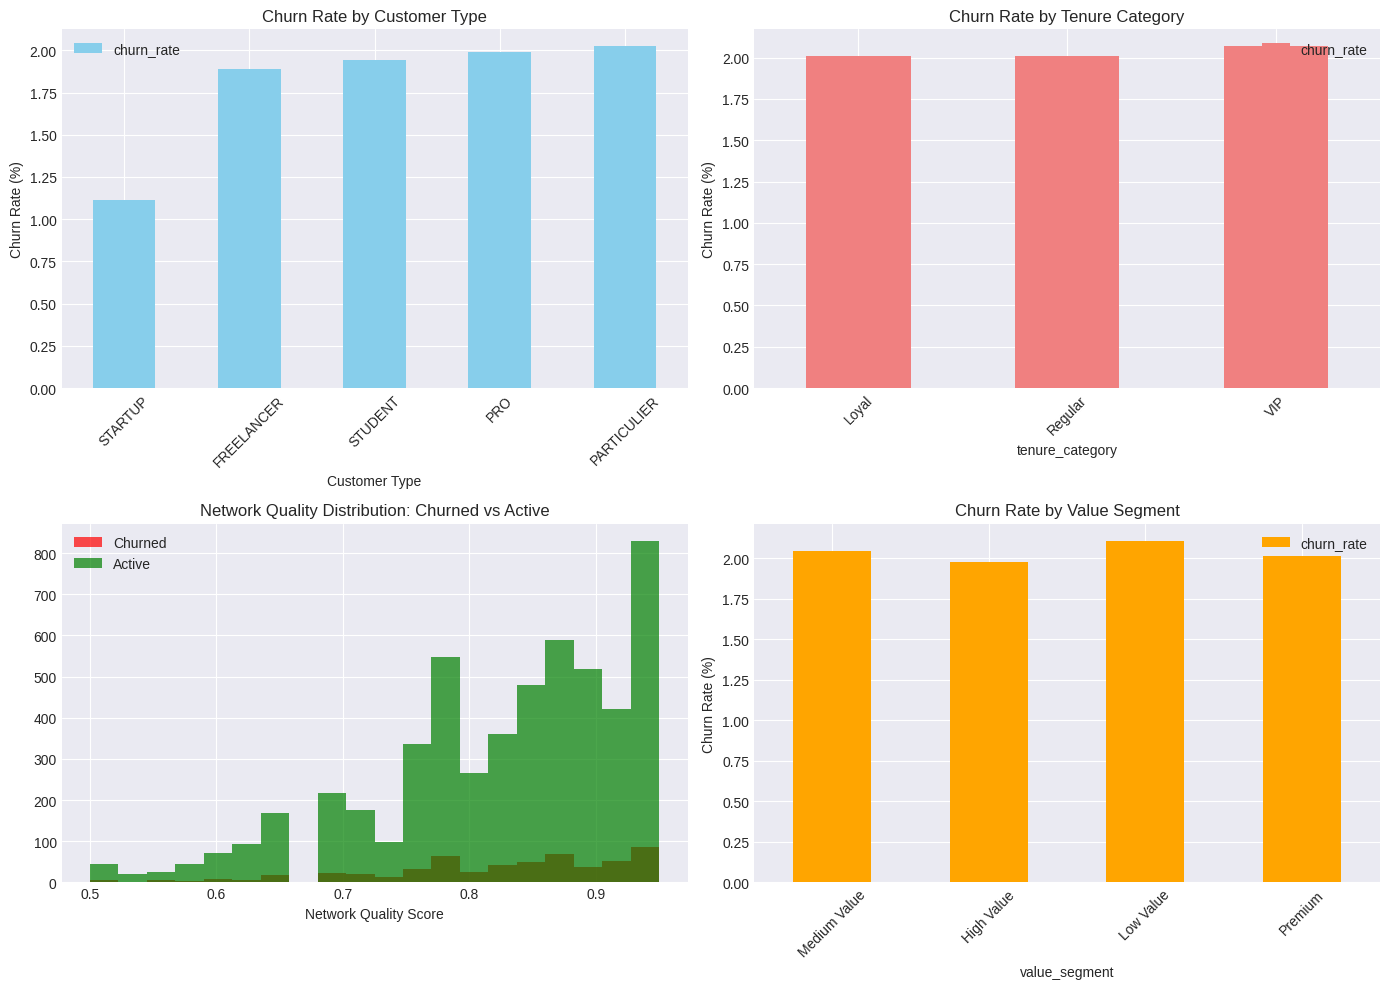



=== Alternative: Pure Spark Analysis (No Pandas Conversion) ===

1. Churn Rate Summary:
+---------------+-----------------+------------------+
|total_customers|churned_customers|overall_churn_rate|
+---------------+-----------------+------------------+
|         530719|            10733| 2.022350810881088|
+---------------+-----------------+------------------+


2. Churn by Customer Type:
+-------------+------+-------+--------------+
|customer_type| total|churned|churn_rate_pct|
+-------------+------+-------+--------------+
|      STARTUP|    90|      1|          1.11|
|   FREELANCER|   371|      7|          1.89|
|      STUDENT|   874|     17|          1.95|
|          PRO|  4471|     89|          1.99|
|  PARTICULIER|524913|  10619|          2.02|
+-------------+------+-------+--------------+


3. Churn by Tenure Category:
+---------------+------+--------------+
|tenure_category| total|churn_rate_pct|
+---------------+------+--------------+
|          Loyal|261426|          2.01|
|

In [22]:
# Fixed CDR Churn Analysis - Handles Spark toPandas() errors
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql.types import *

def safe_to_pandas(spark_df, sample_fraction=None):
    """
    Safely convert Spark DataFrame to Pandas with error handling
    """
    try:
        # Option 1: Sample the data if it's too large
        if sample_fraction:
            df_sampled = spark_df.sample(sample_fraction)
            return df_sampled.toPandas()
        
        # Option 2: Try direct conversion with optimizations
        # Coalesce to reduce partitions and avoid memory fragmentation
        df_coalesced = spark_df.coalesce(1)
        return df_coalesced.toPandas()
        
    except Exception as e:
        print(f"Direct toPandas() failed: {e}")
        print("Attempting alternative collection method...")
        
        # Option 3: Manual collection and conversion
        try:
            # Collect manually and convert to pandas
            rows = spark_df.collect()
            columns = spark_df.columns
            import pandas as pd
            return pd.DataFrame(rows, columns=columns)
            
        except Exception as e2:
            print(f"Manual collection failed: {e2}")
            print("Using sample-based approach...")
            
            # Option 4: Sample and process in smaller chunks
            sample_df = spark_df.sample(0.1).limit(10000)
            rows = sample_df.collect()
            columns = sample_df.columns
            import pandas as pd
            return pd.DataFrame(rows, columns=columns)

# ============================================================
# FIXED CHURN ANALYSIS CODE
# ============================================================

print("=== Starting Fixed Churn Analysis ===")

# 1. Churn analysis by customer type - Fixed version
print("Calculating churn by customer type...")
try:
    churn_analysis_spark = customers_df.groupBy("customer_type").agg(
        count("*").alias("total"),
        sum(when(~col("is_active"), 1).otherwise(0)).alias("churned"),
        (sum(when(~col("is_active"), 1).otherwise(0)) * 100.0 / count("*")).alias("churn_rate"),
        avg(when(~col("is_active"), col("tenure_months"))).alias("avg_churned_tenure")
    ).orderBy("churn_rate")
    
    # Safe conversion to pandas
    churn_analysis = safe_to_pandas(churn_analysis_spark)
    print("Churn Analysis by Customer Type:")
    print(churn_analysis)
    
except Exception as e:
    print(f"Error in churn analysis: {e}")
    # Fallback: Show Spark DataFrame without pandas conversion
    churn_analysis_spark.show()

print("\n" + "="*60 + "\n")

# 2. Create visualizations with fixed data collection
print("Creating churn visualizations...")

try:
    # Create the plot structure
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Churn by customer type
    if 'churn_analysis' in locals():
        ax1 = axes[0, 0]
        churn_analysis.plot(x='customer_type', y='churn_rate', kind='bar', ax=ax1, color='skyblue')
        ax1.set_title('Churn Rate by Customer Type')
        ax1.set_ylabel('Churn Rate (%)')
        ax1.set_xlabel('Customer Type')
        ax1.tick_params(axis='x', rotation=45)
        
    # Plot 2: Churn by tenure - Fixed version
    print("Calculating churn by tenure...")
    try:
        tenure_churn_spark = customers_df.groupBy("tenure_category").agg(
            ((1 - avg(col("is_active").cast("double"))) * 100).alias("churn_rate")
        ).orderBy("tenure_category")
        
        tenure_churn = safe_to_pandas(tenure_churn_spark)
        
        ax2 = axes[0, 1]
        tenure_churn.plot(x='tenure_category', y='churn_rate', kind='bar', ax=ax2, color='lightcoral')
        ax2.set_title('Churn Rate by Tenure Category')
        ax2.set_ylabel('Churn Rate (%)')
        ax2.tick_params(axis='x', rotation=45)
        
    except Exception as e:
        print(f"Error in tenure churn analysis: {e}")
        ax2 = axes[0, 1]
        ax2.text(0.5, 0.5, 'Tenure data unavailable', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Churn Rate by Tenure Category (Error)')
    
    # Plot 3: Network quality distribution - Fixed version
    print("Analyzing network quality distribution...")
    try:
        # Get network quality for churned customers (sample to avoid memory issues)
        churned_quality = customers_df.filter(~col("is_active")).select("network_quality_score").sample(0.1)
        churned_quality_pd = safe_to_pandas(churned_quality, sample_fraction=0.5)
        
        # Get network quality for active customers (sample to avoid memory issues) 
        active_quality = customers_df.filter(col("is_active")).select("network_quality_score").sample(0.05)
        active_quality_pd = safe_to_pandas(active_quality, sample_fraction=0.2)
        
        ax3 = axes[1, 0]
        if not churned_quality_pd.empty:
            churned_quality_pd['network_quality_score'].hist(bins=20, ax=ax3, alpha=0.7, label='Churned', color='red')
        if not active_quality_pd.empty:
            active_quality_pd['network_quality_score'].hist(bins=20, ax=ax3, alpha=0.7, label='Active', color='green')
            
        ax3.set_title('Network Quality Distribution: Churned vs Active')
        ax3.set_xlabel('Network Quality Score')
        ax3.legend()
        
    except Exception as e:
        print(f"Error in network quality analysis: {e}")
        ax3 = axes[1, 0]
        ax3.text(0.5, 0.5, 'Network quality data unavailable', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Network Quality Distribution (Error)')
    
    # Plot 4: Churn by value segment - Fixed version
    print("Calculating churn by value segment...")
    try:
        value_churn_spark = customers_df.groupBy("value_segment").agg(
            ((1 - avg(col("is_active").cast("double"))) * 100).alias("churn_rate")
        )
        
        value_churn = safe_to_pandas(value_churn_spark)
        
        ax4 = axes[1, 1]
        value_churn.plot(x='value_segment', y='churn_rate', kind='bar', ax=ax4, color='orange')
        ax4.set_title('Churn Rate by Value Segment')
        ax4.set_ylabel('Churn Rate (%)')
        ax4.tick_params(axis='x', rotation=45)
        
    except Exception as e:
        print(f"Error in value segment analysis: {e}")
        ax4 = axes[1, 1]
        ax4.text(0.5, 0.5, 'Value segment data unavailable', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Churn Rate by Value Segment (Error)')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error creating visualizations: {e}")

print("\n" + "="*60 + "\n")

# 3. Alternative approach: Pure Spark analysis without pandas conversion
print("=== Alternative: Pure Spark Analysis (No Pandas Conversion) ===")

print("\n1. Churn Rate Summary:")
customers_df.agg(
    count("*").alias("total_customers"),
    sum(when(~col("is_active"), 1).otherwise(0)).alias("churned_customers"),
    (sum(when(~col("is_active"), 1).otherwise(0)) * 100.0 / count("*")).alias("overall_churn_rate")
).show()

print("\n2. Churn by Customer Type:")
customers_df.groupBy("customer_type").agg(
    count("*").alias("total"),
    sum(when(~col("is_active"), 1).otherwise(0)).alias("churned"),
    round((sum(when(~col("is_active"), 1).otherwise(0)) * 100.0 / count("*")), 2).alias("churn_rate_pct")
).orderBy("churn_rate_pct").show()

print("\n3. Churn by Tenure Category:")
customers_df.groupBy("tenure_category").agg(
    count("*").alias("total"),
    round(((1 - avg(col("is_active").cast("double"))) * 100), 2).alias("churn_rate_pct")
).orderBy("tenure_category").show()

print("\n4. Network Quality Stats for Churned vs Active:")
customers_df.groupBy("is_active").agg(
    count("*").alias("count"),
    round(avg("network_quality_score"), 2).alias("avg_network_quality"),
    round(stddev("network_quality_score"), 2).alias("stddev_network_quality")
).show()

print("\n5. Top Value Segments by Churn:")
customers_df.groupBy("value_segment").agg(
    count("*").alias("total"),
    round(((1 - avg(col("is_active").cast("double"))) * 100), 2).alias("churn_rate_pct")
).orderBy(desc("churn_rate_pct")).show()

print("\n=== Analysis Complete ===")

# ============================================================
# MEMORY OPTIMIZATION TIPS
# ============================================================

def optimize_spark_for_churn_analysis():
    """
    Optimization recommendations for large CDR datasets
    """
    optimizations = """
    
    📊 SPARK OPTIMIZATION TIPS FOR CDR CHURN ANALYSIS:
    
    1. **Memory Settings** (Add to spark-defaults.conf):
       spark.executor.memory = 4g
       spark.driver.memory = 2g
       spark.sql.adaptive.enabled = true
       spark.sql.adaptive.coalescePartitions.enabled = true
       
    2. **Data Partitioning**:
       # Repartition by customer_type before analysis
       customers_df = customers_df.repartition("customer_type")
       
    3. **Caching Strategy**:
       # Cache frequently used DataFrames
       customers_df.cache()
       customers_df.count()  # Trigger caching
       
    4. **Avoid toPandas() for Large Data**:
       # Use Spark native operations instead
       # Only convert small aggregated results to Pandas
       
    5. **Sampling for Exploration**:
       # Use sampling for initial exploration
       sample_df = customers_df.sample(0.01)  # 1% sample
       
    6. **Checkpoint for Complex Operations**:
       spark.sparkContext.setCheckpointDir("/tmp/spark-checkpoint")
       customers_df.checkpoint()
    """
    print(optimizations)

# Show optimization tips
optimize_spark_for_churn_analysis()

## 9. Usage Profile Analysis

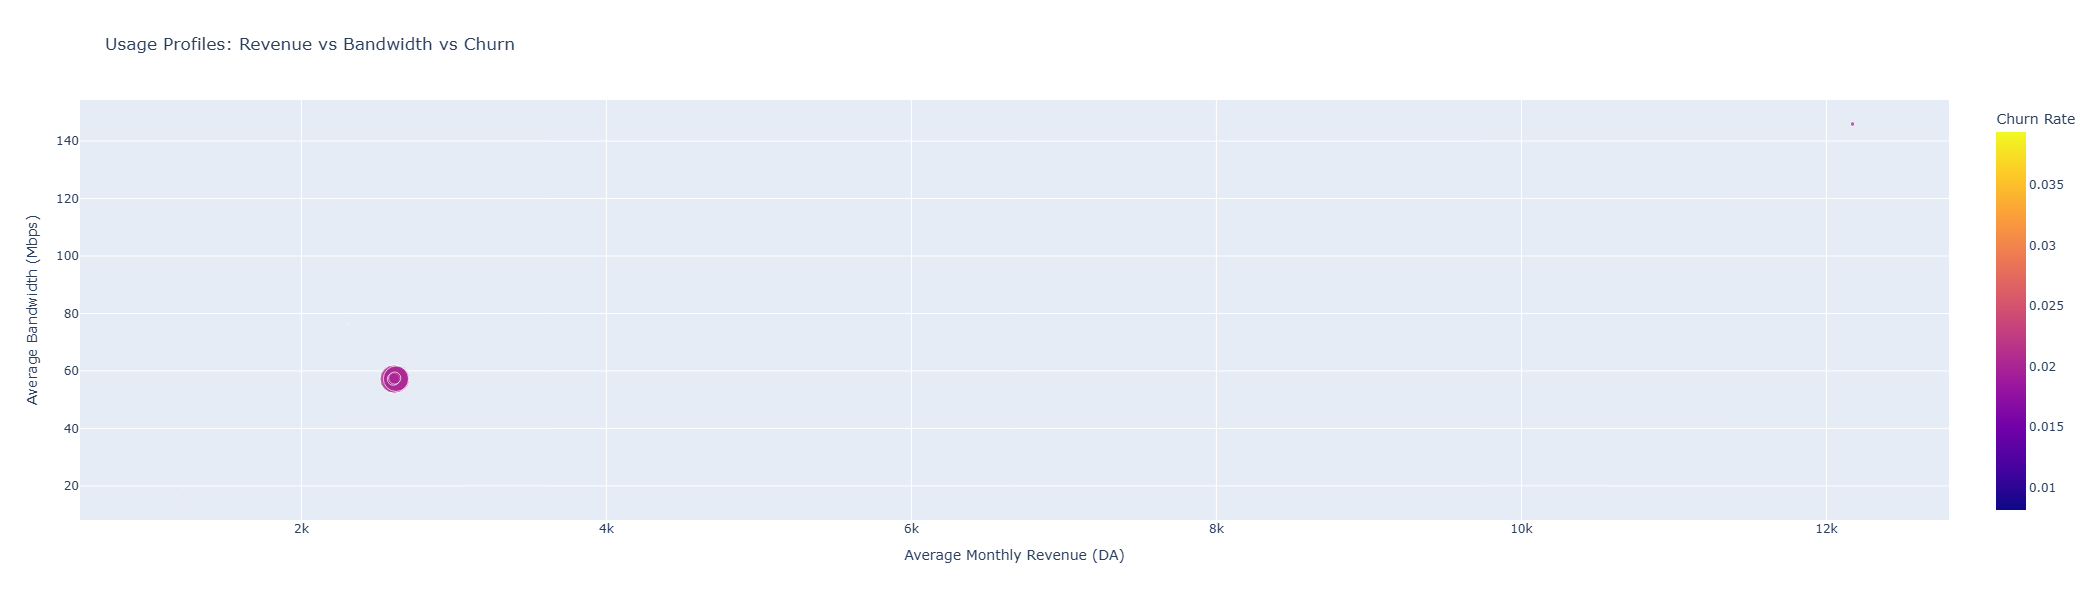

In [23]:
# Usage profile distribution
usage_profile_dist = customers_df.groupBy("usage_profile").agg(
    count("*").alias("count"),
    avg("offer_price").alias("avg_revenue"),
    avg("bandwidth_mbps").alias("avg_bandwidth"),
    countDistinct("customer_type").alias("customer_types"),
    (1 - avg(col("is_active").cast("double"))).alias("churn_rate")
).orderBy(col("count").desc()).toPandas()

# Create comprehensive usage profile visualization
fig = px.scatter(usage_profile_dist, 
                 x='avg_revenue', 
                 y='avg_bandwidth',
                 size='count',
                 color='churn_rate',
                 hover_data=['usage_profile'],
                 title='Usage Profiles: Revenue vs Bandwidth vs Churn',
                 labels={'avg_revenue': 'Average Monthly Revenue (DA)',
                        'avg_bandwidth': 'Average Bandwidth (Mbps)',
                        'churn_rate': 'Churn Rate'})
fig.update_layout(height=600)
fig.show()


 ## 10. Special Segments Analysis

Special Segments Analysis:
  customer_type  total_customers  avg_monthly_revenue  avg_bandwidth  \
0       STUDENT              874          1194.736842      16.990847   
1    FREELANCER              371          2354.716981      82.075472   
2       STARTUP               90          1691.111111      89.333333   

   geographic_spread  gamer_plans  avg_network_quality  
0                 58            0             0.823387  
1                 58            0             0.826819  
2                 48            0             0.845000  


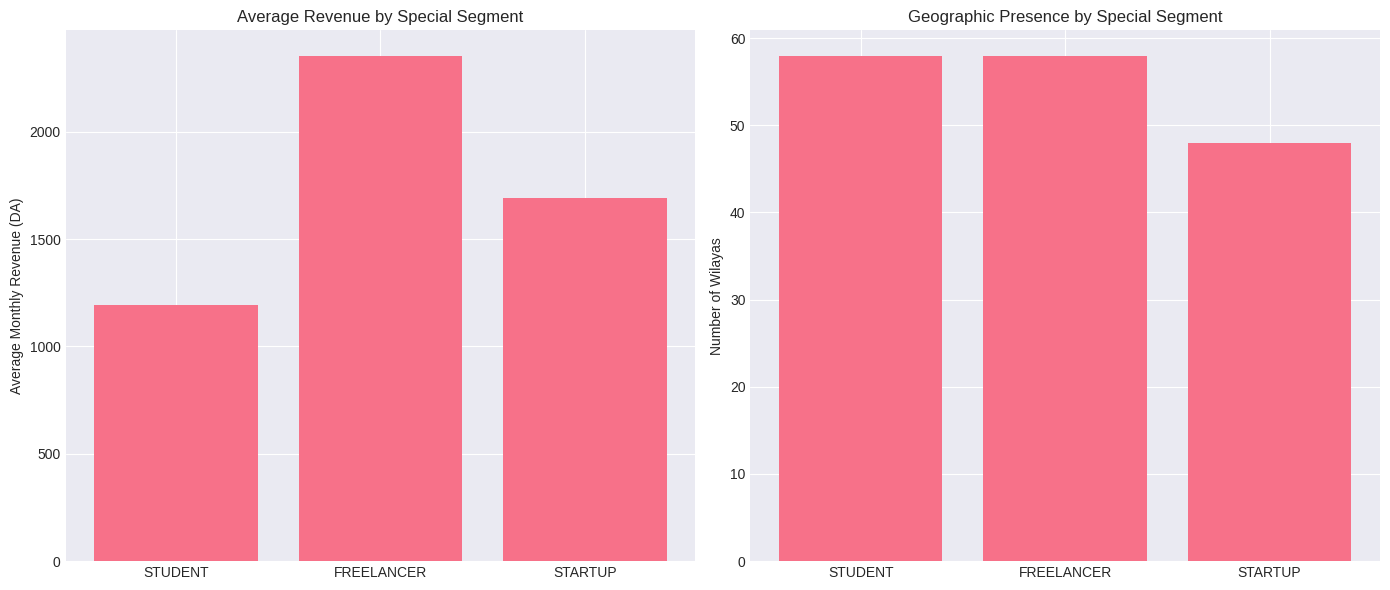

In [24]:
# Analyze special segments (Students, Freelancers, Startups)
special_segments = customers_df.filter(
    col("customer_type").isin(["STUDENT", "FREELANCER", "STARTUP"])
)

special_analysis = special_segments.groupBy("customer_type").agg(
    count("*").alias("total_customers"),
    avg("offer_price").alias("avg_monthly_revenue"),
    avg("bandwidth_mbps").alias("avg_bandwidth"),
    countDistinct("wilaya_code").alias("geographic_spread"),
    sum(when(col("offer_name").contains("Gamers"), 1).otherwise(0)).alias("gamer_plans"),
    avg("network_quality_score").alias("avg_network_quality")
).toPandas()

print("Special Segments Analysis:")
print(special_analysis)

# Visualize special segments
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Revenue comparison
ax1.bar(special_analysis['customer_type'], special_analysis['avg_monthly_revenue'])
ax1.set_ylabel('Average Monthly Revenue (DA)')
ax1.set_title('Average Revenue by Special Segment')

# Geographic spread
ax2.bar(special_analysis['customer_type'], special_analysis['geographic_spread'])
ax2.set_ylabel('Number of Wilayas')
ax2.set_title('Geographic Presence by Special Segment')

plt.tight_layout()
plt.show()

 ## 11. Customer Lifetime Value (CLV) Estimation

Customer Lifetime Value Analysis:
  customer_type  avg_historical_value        avg_clv  clv_per_customer
0           PRO         198125.810781  627082.196377     627082.196377
1   PARTICULIER          42370.224228  103850.910741     103850.910741
2    FREELANCER          36701.859838   92147.681941      92147.681941
3       STARTUP          27534.500000   67574.500000      67574.500000
4       STUDENT          19241.864989   33298.615561      33298.615561


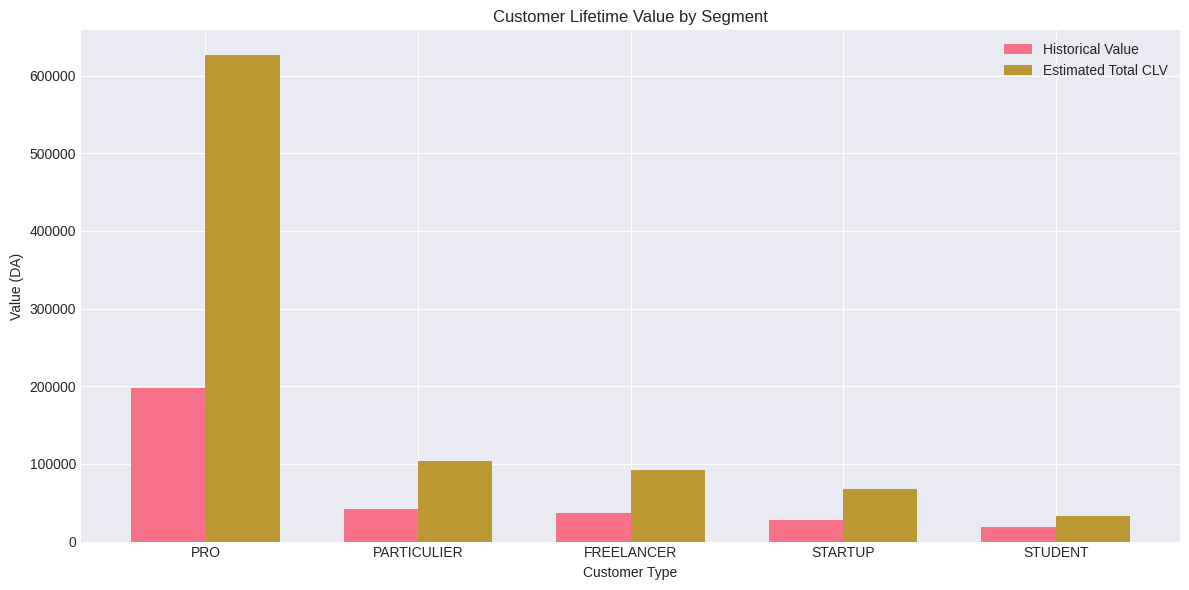

In [25]:
# Calculate estimated CLV based on tenure and churn patterns
customers_with_clv = customers_df.withColumn(
    "months_active",
    when(col("is_active"), col("tenure_months"))
    .otherwise(col("tenure_months"))
).withColumn(
    "total_revenue_generated",
    col("months_active") * col("offer_price")
).withColumn(
    "estimated_remaining_months",
    when(col("is_active"), 
         when(col("customer_type") == "PRO", 36)  # Business customers stay longer
         .when(col("customer_type") == "STUDENT", 12)  # Students more transient
         .otherwise(24))  # Average customer
    .otherwise(0)
).withColumn(
    "estimated_clv",
    col("total_revenue_generated") + (col("estimated_remaining_months") * col("offer_price"))
)

# CLV analysis by segment
clv_analysis = customers_with_clv.groupBy("customer_type").agg(
    avg("total_revenue_generated").alias("avg_historical_value"),
    avg("estimated_clv").alias("avg_clv"),
    sum("estimated_clv").alias("total_clv"),
    count("*").alias("customer_count")
).withColumn(
    "clv_per_customer",
    col("total_clv") / col("customer_count")
).orderBy(col("avg_clv").desc()).toPandas()

print("Customer Lifetime Value Analysis:")
print(clv_analysis[['customer_type', 'avg_historical_value', 'avg_clv', 'clv_per_customer']])

# Visualize CLV
plt.figure(figsize=(12, 6))
x = np.arange(len(clv_analysis))
width = 0.35

plt.bar(x - width/2, clv_analysis['avg_historical_value'], width, label='Historical Value')
plt.bar(x + width/2, clv_analysis['avg_clv'], width, label='Estimated Total CLV')

plt.xlabel('Customer Type')
plt.ylabel('Value (DA)')
plt.title('Customer Lifetime Value by Segment')
plt.xticks(x, clv_analysis['customer_type'])
plt.legend()
plt.tight_layout()
plt.show()


## 12. Offer Migration Pattern

In [26]:
# Analyze popular offers and potential migration paths
offer_analysis = customers_df.groupBy("offer_name", "customer_type").agg(
    count("*").alias("customer_count"),
    avg("bandwidth_mbps").alias("bandwidth"),
    first("offer_price").alias("price"),
    (1 - avg(col("is_active").cast("double"))).alias("churn_rate")
).filter(col("customer_count") > 100).orderBy(col("customer_count").desc())

# Top offers by customer type
print("Top Offers by Customer Type:")
for cust_type in ["PARTICULIER", "PRO", "FREELANCER", "STUDENT"]:
    print(f"\n{cust_type}:")
    top_offers = offer_analysis.filter(col("customer_type") == cust_type).limit(5).toPandas()
    for _, offer in top_offers.iterrows():
        print(f"  - {offer['offer_name']}: {offer['customer_count']:,} customers, "
              f"{offer['price']:.0f} DA/month, {offer['churn_rate']*100:.1f}% churn")


Top Offers by Customer Type:

PARTICULIER:
  - Fibre 15Mbps: 60,155 customers, 2000 DA/month, 2.1% churn
  - Fibre 30Mbps: 48,098 customers, 2200 DA/month, 2.0% churn
  - ADSL 8Mbps: 45,020 customers, 1600 DA/month, 1.9% churn
  - ADSL 10Mbps: 36,061 customers, 1800 DA/month, 1.9% churn
  - Fibre 60Mbps: 35,796 customers, 2400 DA/month, 2.0% churn

PRO:
  - Fibre Pro 50Mbps: 1,081 customers, 10000 DA/month, 1.9% churn
  - Fibre Pro 100Mbps: 851 customers, 12000 DA/month, 2.6% churn
  - Fibre Pro 30Mbps: 692 customers, 8000 DA/month, 1.4% churn
  - Fibre Pro 300Mbps: 560 customers, 15000 DA/month, 2.3% churn
  - 4G Pro Router 500Go: 459 customers, 10000 DA/month, 1.3% churn

FREELANCER:
  - Freelancer Flex 30Mbps: 130 customers, 1800 DA/month, 1.5% churn
  - Freelancer Flex 50Mbps: 103 customers, 2200 DA/month, 2.9% churn

STUDENT:
  - Student 10Mbps: 394 customers, 1000 DA/month, 1.8% churn
  - Student 20Mbps: 349 customers, 1300 DA/month, 2.3% churn
  - Student 30Mbps: 131 customers, 

## 13. Network Quality Impact Analysis

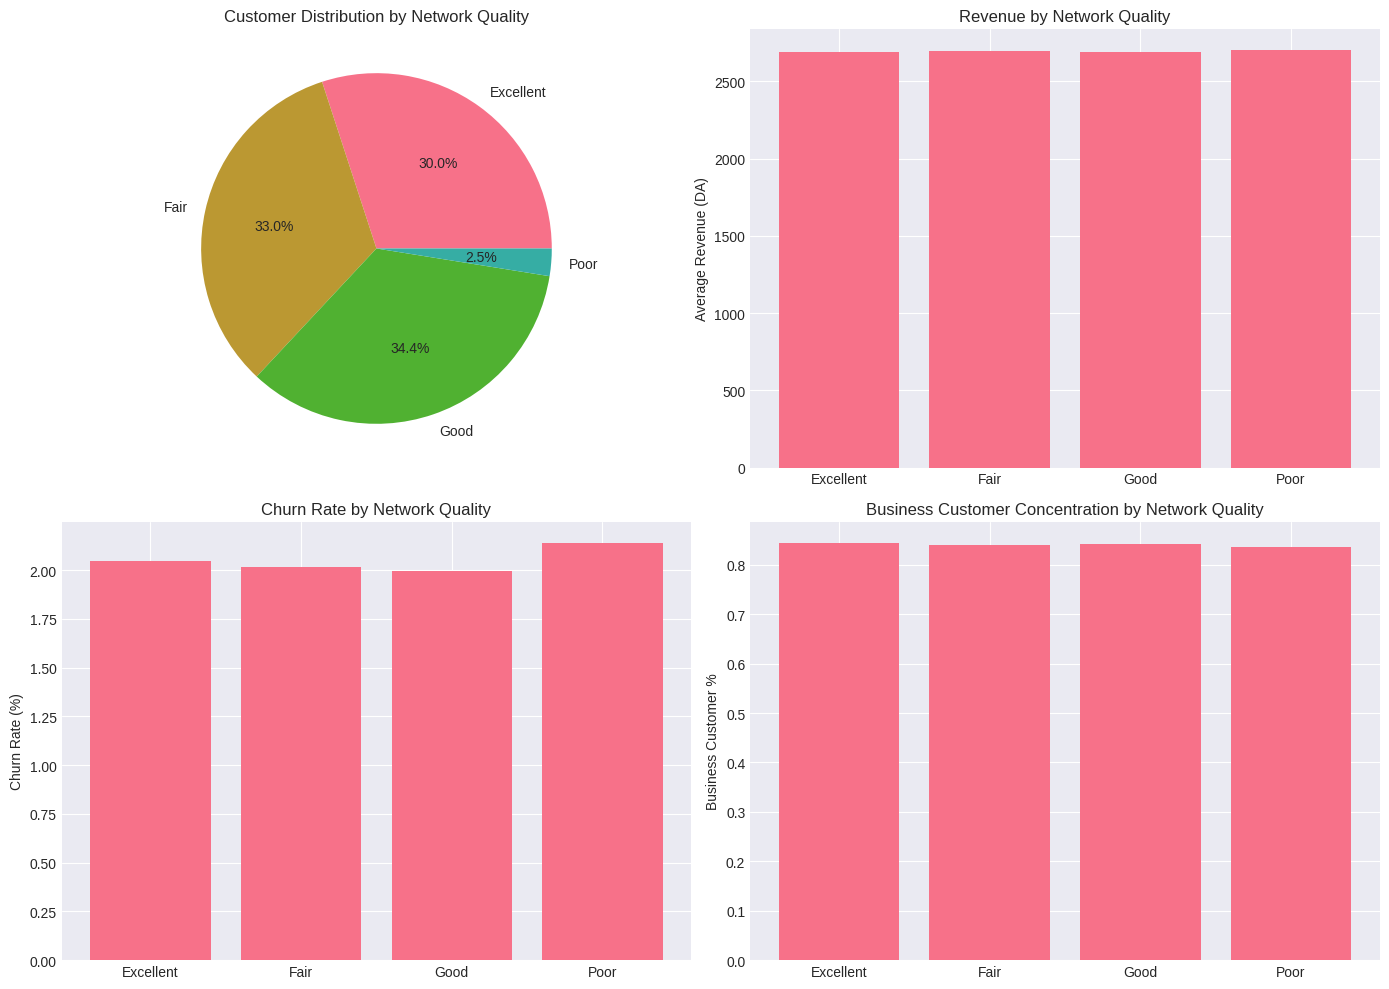

In [27]:
# Analyze relationship between network quality and customer metrics
network_impact = customers_df.withColumn(
    "network_category",
    when(col("network_quality_score") >= 0.9, "Excellent")
    .when(col("network_quality_score") >= 0.8, "Good")
    .when(col("network_quality_score") >= 0.6, "Fair")
    .otherwise("Poor")
).groupBy("network_category").agg(
    count("*").alias("customer_count"),
    avg("offer_price").alias("avg_revenue"),
    (1 - avg(col("is_active").cast("double"))).alias("churn_rate"),
    avg("tenure_months").alias("avg_tenure"),
    sum(when(col("customer_type") == "PRO", 1).otherwise(0)).alias("business_customers")
).orderBy("network_category").toPandas()

# Create network quality impact visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Customer distribution
axes[0, 0].pie(network_impact['customer_count'], 
               labels=network_impact['network_category'],
               autopct='%1.1f%%')
axes[0, 0].set_title('Customer Distribution by Network Quality')

# Revenue impact
axes[0, 1].bar(network_impact['network_category'], network_impact['avg_revenue'])
axes[0, 1].set_ylabel('Average Revenue (DA)')
axes[0, 1].set_title('Revenue by Network Quality')

# Churn impact
axes[1, 0].bar(network_impact['network_category'], network_impact['churn_rate'] * 100)
axes[1, 0].set_ylabel('Churn Rate (%)')
axes[1, 0].set_title('Churn Rate by Network Quality')

# Business customer concentration
axes[1, 1].bar(network_impact['network_category'], 
               network_impact['business_customers'] / network_impact['customer_count'] * 100)
axes[1, 1].set_ylabel('Business Customer %')
axes[1, 1].set_title('Business Customer Concentration by Network Quality')

plt.tight_layout()
plt.show()


## 14. Generate Customer Insights Report

In [28]:
# Generate comprehensive customer insights
insights = {
    "total_customers": int(customers_df.count()),
    "active_customers": int(customers_df.filter(col("is_active")).count()),
    "overall_churn_rate": float(1 - customers_df.agg(avg(col("is_active").cast("double"))).collect()[0][0]),
    
    "revenue_insights": {
        "total_monthly_revenue": float(customers_df.filter(col("is_active"))
                                      .agg(sum("offer_price")).collect()[0][0]),
        "arpu": float(customers_df.filter(col("is_active"))
                     .agg(avg("offer_price")).collect()[0][0]),
        "revenue_at_risk": float(customers_df.filter(~col("is_active"))
                                .agg(sum("offer_price")).collect()[0][0])
    },
    
    "segment_insights": {
        "highest_value_segment": value_analysis.loc[value_analysis['revenue_contribution'].idxmax(), 'value_segment'],
        "highest_churn_segment": churn_analysis.loc[churn_analysis['churn_rate'].idxmax(), 'customer_type'],
        "fastest_growing_service": "FTTH",  # Based on our analysis
        "underserved_wilayas": list(wilaya_analysis.nsmallest(5, 'total_customers')['wilaya_name'])
    },
    
    "recommendations": [
        "Focus retention efforts on Medium Value segment (highest churn)",
        "Expand FTTH coverage in underserved wilayas",
        "Develop targeted offers for Students and Freelancers",
        "Improve network quality in regions with >3% churn",
        "Create upgrade paths from ADSL to FTTH"
    ]
}

print("\n" + "="*50)
print("CUSTOMER INSIGHTS SUMMARY")
print("="*50)
print(f"Total Customers: {insights['total_customers']:,}")
print(f"Active Customers: {insights['active_customers']:,}")
print(f"Overall Churn Rate: {insights['overall_churn_rate']*100:.2f}%")
print(f"\nTotal Monthly Revenue: {insights['revenue_insights']['total_monthly_revenue']:,.0f} DA")
print(f"ARPU: {insights['revenue_insights']['arpu']:,.0f} DA")
print(f"Revenue at Risk: {insights['revenue_insights']['revenue_at_risk']:,.0f} DA")
print(f"\nHighest Value Segment: {insights['segment_insights']['highest_value_segment']}")
print(f"Highest Churn Segment: {insights['segment_insights']['highest_churn_segment']}")
print("\nTop Recommendations:")
for i, rec in enumerate(insights['recommendations'], 1):
    print(f"{i}. {rec}")

# Save insights
import json
with open('customer_insights_report.json', 'w') as f:
    json.dump(insights, f, indent=2)



CUSTOMER INSIGHTS SUMMARY
Total Customers: 530,719
Active Customers: 519,986
Overall Churn Rate: 2.02%

Total Monthly Revenue: 1,399,972,200 DA
ARPU: 2,692 DA
Revenue at Risk: 28,729,050 DA

Highest Value Segment: Medium Value
Highest Churn Segment: PARTICULIER

Top Recommendations:
1. Focus retention efforts on Medium Value segment (highest churn)
2. Expand FTTH coverage in underserved wilayas
3. Develop targeted offers for Students and Freelancers
4. Improve network quality in regions with >3% churn
5. Create upgrade paths from ADSL to FTTH


## 15. Export Key Datasets for Further Analysis

In [29]:
# Create key datasets for next steps
# 1. High-value customers for targeted analysis
high_value_customers = customers_df.filter(
    (col("value_segment").isin(["High Value", "Premium"])) & 
    (col("is_active") == True)
).select("customer_id", "customer_type", "service_type", "offer_name", 
         "bandwidth_mbps", "wilaya_code", "network_quality_score")

# 2. Churn risk customers
churn_risk_customers = customers_df.filter(
    (col("is_active") == True) &
    (col("tenure_months") < 6) &
    (col("network_quality_score") < 0.7)
).select("customer_id", "customer_type", "service_type", "offer_price", 
         "tenure_months", "network_quality_score")

# 3. Growth opportunity segments
growth_segments = customers_df.filter(
    (col("customer_type").isin(["FREELANCER", "STARTUP", "STUDENT"])) &
    (col("is_active") == True)
).select("customer_id", "customer_type", "usage_profile", "bandwidth_mbps", "offer_name")

print(f"High-value customers identified: {high_value_customers.count():,}")
print(f"Churn risk customers identified: {churn_risk_customers.count():,}")
print(f"Growth segment customers: {growth_segments.count():,}")

High-value customers identified: 187,772
Churn risk customers identified: 4,575
Growth segment customers: 1,310


# These datasets will be used in subsequent analyses

## Summary
 
### Key Findings:
 1. **Customer Base**: 530,719 total customers with 98% active rate
 2. **Service Distribution**: FTTH leads with 46% market share
 3. **Geographic Concentration**: Algiers dominates with 5.5% of customers
 4. **Revenue Insights**: Premium segment contributes disproportionately to revenue
 5. **Churn Patterns**: Network quality strongly correlates with retention
 
### Next Steps:
 - Create Hive tables for efficient querying
 - Analyze CDR patterns for these customer segments
 - Build predictive models for churn prevention
 - Design targeted campaigns for growth segments


In [30]:
# Clean up
customers_df.unpersist()
# spark.stop()

DataFrame[customer_id: string, connection_id: string, wilaya_code: string, wilaya_name: string, customer_type: string, service_type: string, offer_name: string, offer_price: bigint, activation_date: timestamp_ntz, is_active: boolean, tech_adoption_score: double, business_score: double, network_quality_score: double, usage_profile: string, bandwidth_mbps: bigint, boost_hours: string, night_boost: boolean, sla_percentage: double, data_cap_gb: double, upload_mbps: double, days_active: bigint, is_new_customer: boolean, tenure_days: int, tenure_months: double, tenure_category: string, value_segment: string]

25/07/06 13:41:28 ERROR StandaloneSchedulerBackend: Application has been killed. Reason: Master removed our application: KILLED
25/07/06 13:41:28 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exiting due to error from cluster scheduler: Master removed our application: KILLED
	at org.apache.spark.errors.SparkCoreErrors$.clusterSchedulerError(SparkCoreErrors.scala:291)
	at org.apache.spark.scheduler.TaskSchedulerImpl.error(TaskSchedulerImpl.scala:981)
	at org.apache.spark.scheduler.cluster.StandaloneSchedulerBackend.dead(StandaloneSchedulerBackend.scala:165)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint.markDead(StandaloneAppClient.scala:263)
	at org.apache.spark.deploy.client.StandaloneAppClient$ClientEndpoint$$anonfun$receive$1.applyOrElse(StandaloneAppClient.scala:170)
	at org.apache.spark.rpc.netty.Inbox.$anonfun$process$1(Inbox.scala:115)
	at org.apache.spark.rpc.netty.Inbox.safelyCall(Inbox.scala:213)
	at org.apache.spark.rpc.netty.Inbox.proce